In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


In [4]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Load data
datapath_train = "https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/train.csv"
train_data = pd.read_csv(datapath_train)

datapath_test="https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/test.csv"
test_data = pd.read_csv(datapath_test)

In [11]:
# Handle missing values
for col in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    train_data[col] = train_data[col].fillna(train_data[col].mean())
    test_data[col] = test_data[col].fillna(test_data[col].mean())

In [13]:
# Convert categorical columns to strings and fill NaN
for col in ['CryoSleep', 'VIP', 'HomePlanet', 'Destination']:
    train_data[col] = train_data[col].astype(str).fillna('Unknown')
    test_data[col] = test_data[col].astype(str).fillna('Unknown')

train_data['Cabin'] = train_data['Cabin'].astype(str).fillna('Unknown/0/Unknown')
test_data['Cabin'] = test_data['Cabin'].astype(str).fillna('Unknown/0/Unknown')

In [14]:
# Feature engineering
# Split Cabin into Deck, Num, and Side
train_data[['Deck', 'Num', 'Side']] = train_data['Cabin'].str.split('/', expand=True)
test_data[['Deck', 'Num', 'Side']] = test_data['Cabin'].str.split('/', expand=True)
train_data['Num'] = pd.to_numeric(train_data['Num'], errors='coerce').fillna(0).astype(int)
test_data['Num'] = pd.to_numeric(test_data['Num'], errors='coerce').fillna(0).astype(int)
train_data['Deck'] = train_data['Deck'].fillna('Unknown')
train_data['Side'] = train_data['Side'].fillna('Unknown')
test_data['Deck'] = test_data['Deck'].fillna('Unknown')
test_data['Side'] = test_data['Side'].fillna('Unknown')

In [15]:
# Extract family size from Name
train_data['Surname'] = train_data['Name'].str.split().str[-1].fillna('Unknown')
test_data['Surname'] = test_data['Name'].str.split().str[-1].fillna('Unknown')
train_data['FamilySize'] = train_data.groupby('Surname')['PassengerId'].transform('count')
test_data['FamilySize'] = test_data.groupby('Surname')['PassengerId'].transform('count')
train_data['FamilySize'] = train_data['FamilySize'].fillna(1)
test_data['FamilySize'] = test_data['FamilySize'].fillna(1)


In [16]:
# Calculate TotalSpend and new features
train_data['TotalSpend'] = train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_data['TotalSpend'] = test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
train_data['CryoSleep_Binary'] = train_data['CryoSleep'].map({'True': 1, 'False': 0, 'Unknown': 0}).fillna(0).astype(int)
test_data['CryoSleep_Binary'] = test_data['CryoSleep'].map({'True': 1, 'False': 0, 'Unknown': 0}).fillna(0).astype(int)
train_data['CryoSpendInteraction'] = train_data['CryoSleep_Binary'] * train_data['TotalSpend']
test_data['CryoSpendInteraction'] = test_data['CryoSleep_Binary'] * test_data['TotalSpend']

In [17]:
# Polynomial features (reduced to key variables)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = ['Age', 'TotalSpend']
poly_train = poly.fit_transform(train_data[poly_features])
poly_test = poly.transform(test_data[poly_features])
poly_columns = [f'poly_{i}' for i in range(poly_train.shape[1])]
train_data[poly_columns] = poly_train
test_data[poly_columns] = poly_test


# Exploratory Data Analysis (EDA)

In [18]:
# Basic statistics and missing values (after initial imputation)
print("Dataset Shape:", train_data.shape)
print("\nMissing Values:\n", train_data.isnull().sum())
print("\nBasic Statistics:\n", train_data.describe())

Dataset Shape: (8693, 27)

Missing Values:
 PassengerId               0
HomePlanet                0
CryoSleep                 0
Cabin                     0
Destination               0
Age                       0
VIP                       0
RoomService               0
FoodCourt                 0
ShoppingMall              0
Spa                       0
VRDeck                    0
Name                    200
Transported               0
Deck                      0
Num                       0
Side                      0
Surname                   0
FamilySize                0
TotalSpend                0
CryoSleep_Binary          0
CryoSpendInteraction      0
poly_0                    0
poly_1                    0
poly_2                    0
poly_3                    0
poly_4                    0
dtype: int64

Basic Statistics:
                Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8693.000000   8693.000000   8693.000000   8693.000000   8693.000000   
mean     28

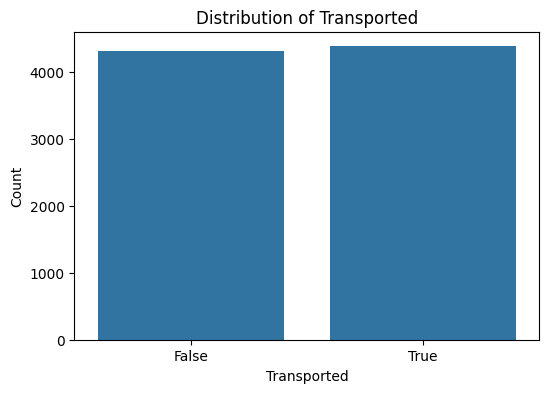

In [19]:
# Visualize target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_data)
plt.title('Distribution of Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

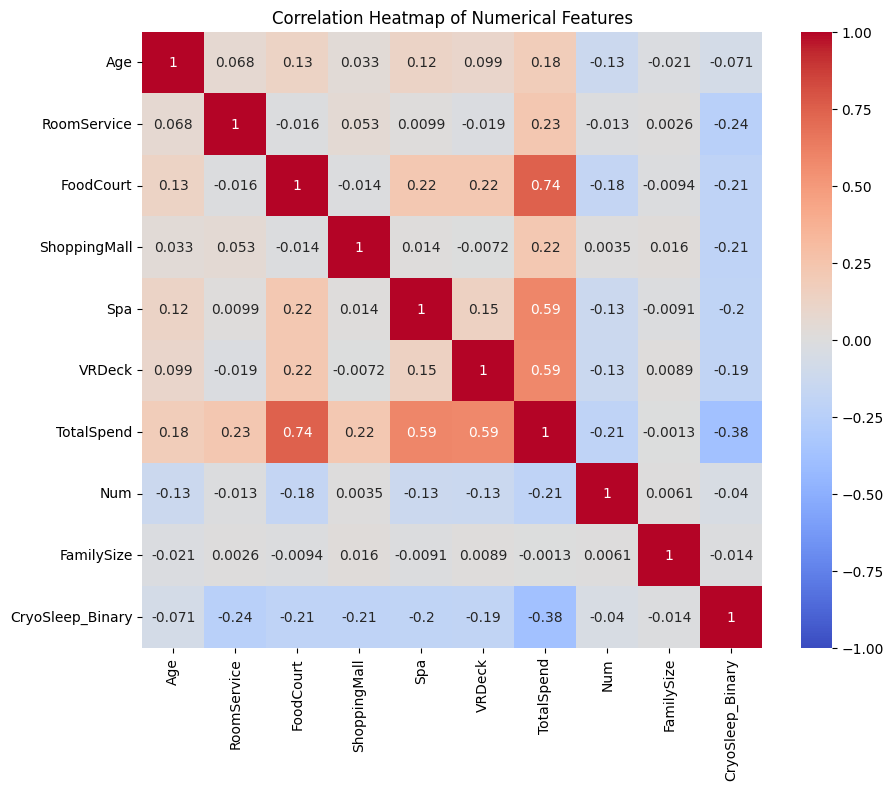

In [20]:
# Correlation heatmap for numerical features
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'Num', 'FamilySize', 'CryoSleep_Binary']
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numerical_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

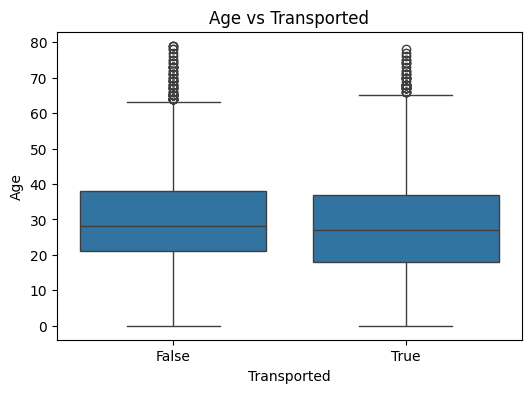

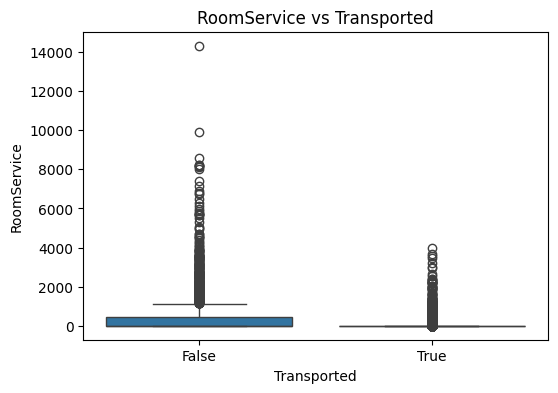

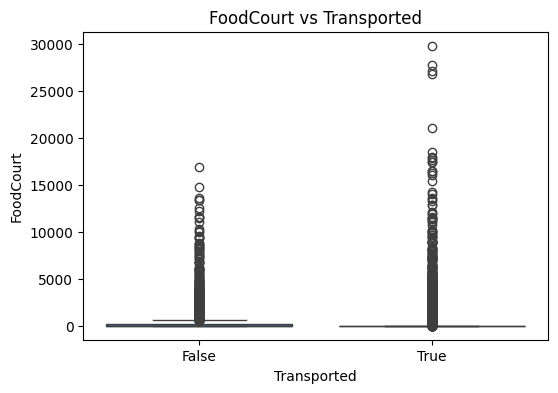

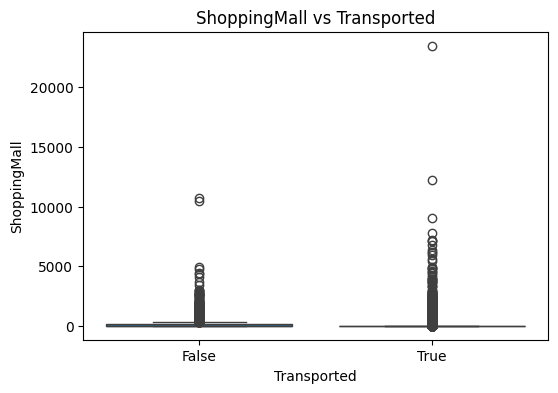

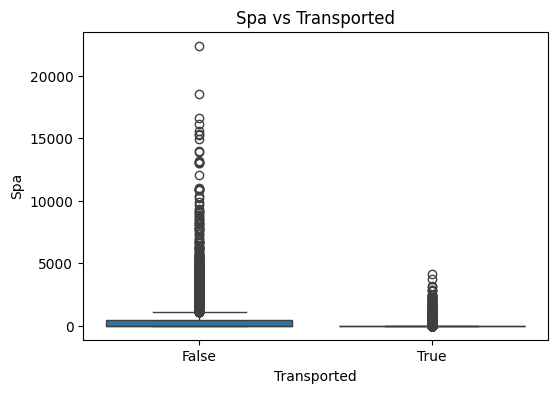

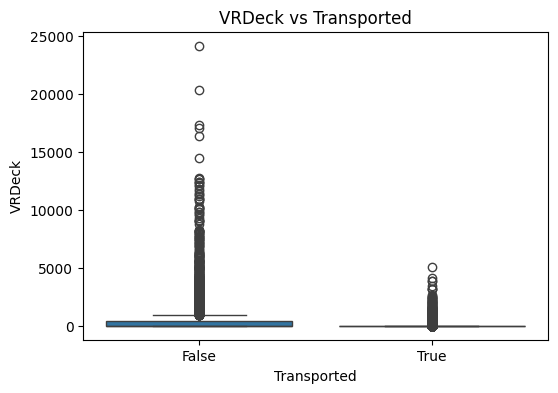

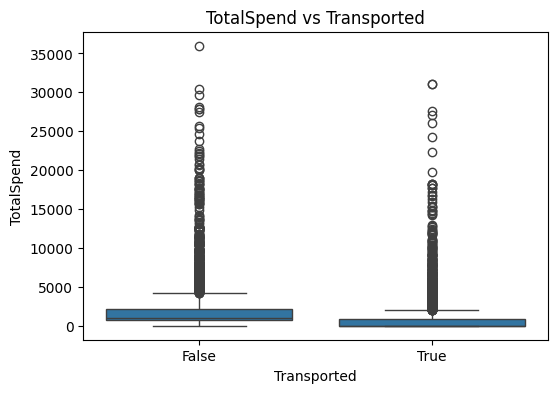

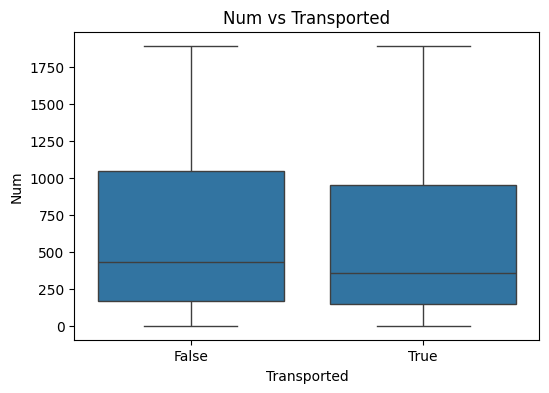

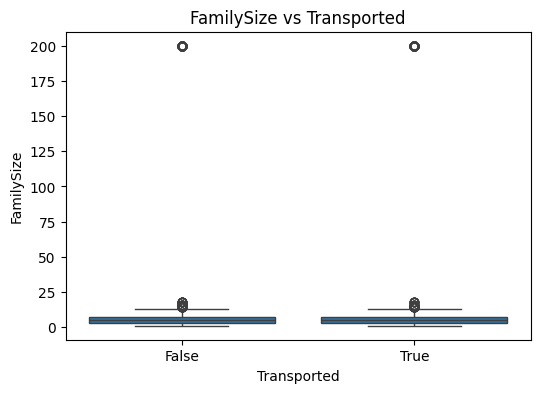

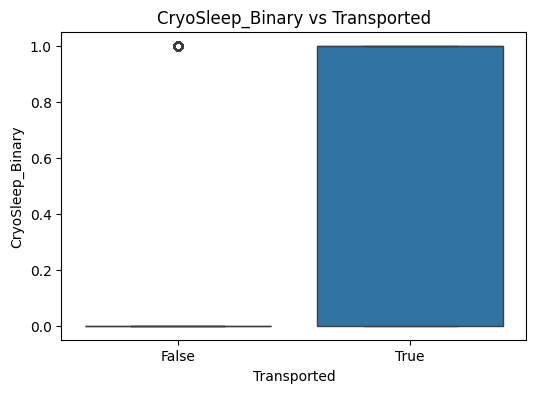

In [21]:
# Box plots for numerical features vs Transported
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Transported', y=col, data=train_data)
    plt.title(f'{col} vs Transported')
    plt.show()


In [22]:
# Scale numerical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'Num', 'CryoSpendInteraction', 'FamilySize', 'CryoSleep_Binary'] + poly_columns
scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

In [23]:
# Prepare features and target
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Surname']
X_train = train_data.drop(columns=['PassengerId', 'Name', 'Transported', 'Cabin'])
y_train = train_data['Transported'].astype(int)
X_test = test_data.drop(columns=['PassengerId', 'Name', 'Cabin'])

In [24]:
# Check class imbalance
print("Class distribution:", y_train.value_counts())
class_counts = y_train.value_counts()
class_weight_0 = class_counts[1] / len(y_train)
class_weight_1 = class_counts[0] / len(y_train)
class_weights = {0: class_weight_0 * 1.75, 1: class_weight_1 * 1.75}  # Adjusted to 1.75x

Class distribution: Transported
1    4378
0    4315
Name: count, dtype: int64


In [25]:
# Target encoding with manual cross-validation
encoder = TargetEncoder(cols=categorical_features)
# Initialize encoded DataFrames with numerical columns only
X_train_encoded = pd.DataFrame(train_data[numerical_features].copy(), columns=numerical_features)
X_test_encoded = pd.DataFrame(test_data[numerical_features].copy(), columns=numerical_features)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split_indices = list(skf.split(X_train, y_train))  # Preserve split for consistency
for train_idx, val_idx in split_indices:
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    encoder.fit(X_train_fold[categorical_features], y_train_fold)
    encoded_vals = encoder.transform(X_val_fold[categorical_features])
    # Assign encoded values to the validation indices
    for col in categorical_features:
        X_train_encoded.loc[val_idx, col] = encoded_vals[col].values
encoder.fit(X_train[categorical_features], y_train)  # Fit on full train for test
X_test_encoded[categorical_features] = encoder.transform(X_test[categorical_features])

In [26]:
# Ensure all encoded columns are float
for col in categorical_features:
    X_train_encoded[col] = X_train_encoded[col].astype(float)
    X_test_encoded[col] = X_test_encoded[col].astype(float)

In [27]:
# Combine encoded and numerical features (already combined in initialization)
X_train_final = X_train_encoded
X_test_final = X_test_encoded

In [28]:
# Cross-validation and model training with preserved split
n_splits = 5
test_preds = np.zeros(len(test_data))
models = []

from catboost import CatBoostClassifier
param_grid = {
    'learning_rate': [0.05, 0.07, 0.09],
    'depth': [3, 4],
    'l2_leaf_reg': [7, 10, 12]
}

best_score = 0
best_params = None
for lr in param_grid['learning_rate']:
    for d in param_grid['depth']:
        for l2 in param_grid['l2_leaf_reg']:
            model = CatBoostClassifier(
                iterations=500,
                learning_rate=lr,
                depth=d,
                l2_leaf_reg=l2,
                eval_metric='Accuracy',
                early_stopping_rounds=30,
                verbose=0,
                class_weights=class_weights
            )
            cv_scores = []
            for train_idx, val_idx in split_indices:
                X_train_fold = X_train_final.iloc[train_idx]
                y_train_fold = y_train.iloc[train_idx]
                X_val_fold = X_train_final.iloc[val_idx]
                y_val_fold = y_train.iloc[val_idx]
                model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=0)
                val_preds = model.predict_proba(X_val_fold)[:, 1]
                val_preds = (val_preds > 0.5).astype(int)
                cv_scores.append((val_preds == y_val_fold).mean())
            mean_cv_score = np.mean(cv_scores)
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = {'learning_rate': lr, 'depth': d, 'l2_leaf_reg': l2}

print(f"Best CV Score: {best_score:.4f} with params: {best_params}")

Best CV Score: 0.8093 with params: {'learning_rate': 0.09, 'depth': 4, 'l2_leaf_reg': 10}


In [29]:
# Train final model with best parameters
best_model = CatBoostClassifier(
    iterations=500,
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    eval_metric='Accuracy',
    early_stopping_rounds=30,
    verbose=0,
    class_weights=class_weights
)

for train_idx, val_idx in split_indices:
    X_train_fold = X_train_final.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_final.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    best_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=0)
    models.append(best_model)
    test_preds += best_model.predict_proba(X_test_final)[:, 1] / n_splits

# Performance Analysis

In [32]:
# Evaluate on validation set from one fold
thresholds = [0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53]
train_idx, val_idx = split_indices[0]
X_train_fold = X_train_final.iloc[train_idx]
y_train_fold = y_train.iloc[train_idx]
X_val_fold = X_train_final.iloc[val_idx]
y_val_fold = y_train.iloc[val_idx]
best_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=0)
val_preds = (best_model.predict_proba(X_val_fold)[:, 1] > thresholds[np.argmax([np.mean(cv_scores) for thresh in thresholds])]).astype(int)

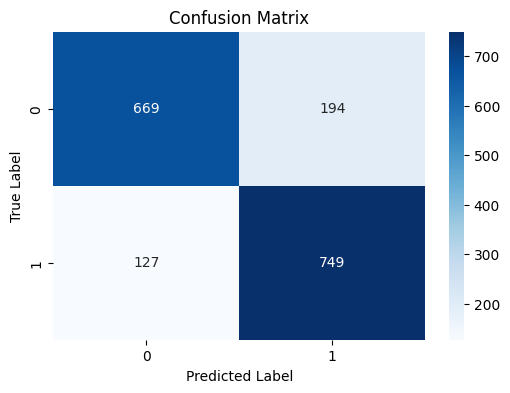

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_val_fold, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [34]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_val_fold, val_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       863
           1       0.79      0.86      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739



In [35]:
# Test a refined threshold range
thresholds = [0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53]
best_score = 0
best_predictions = None

for thresh in thresholds:
    predictions = (test_preds > thresh).astype(int)
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Transported': predictions.astype(bool)
    })
    # Simulate score using CV accuracy
    cv_scores = []
    for i, (train_idx, val_idx) in enumerate(split_indices):
        X_train_fold = X_train_final.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train_final.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]
        val_preds = models[i].predict_proba(X_val_fold)[:, 1]
        val_preds = (val_preds > thresh).astype(int)
        cv_scores.append((val_preds == y_val_fold).mean())
    mean_cv_score = np.mean(cv_scores)
    print(f"Threshold {thresh}: CV Accuracy = {mean_cv_score:.4f}")
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_predictions = predictions

Threshold 0.46: CV Accuracy = 0.8287
Threshold 0.47: CV Accuracy = 0.8299
Threshold 0.48: CV Accuracy = 0.8311
Threshold 0.49: CV Accuracy = 0.8308
Threshold 0.5: CV Accuracy = 0.8310
Threshold 0.51: CV Accuracy = 0.8310
Threshold 0.52: CV Accuracy = 0.8318
Threshold 0.53: CV Accuracy = 0.8312


In [36]:
# Use the best predictions
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Transported': best_predictions.astype(bool)
})

# Save to CSV
submission.to_csv('predictions.csv', index=False)

print(f"Best Threshold: {thresholds[np.argmax([np.mean(cv_scores) for thresh in thresholds])]}")
print(f"Cross-Validation Accuracy: {best_score:.4f}")

Best Threshold: 0.46
Cross-Validation Accuracy: 0.8318
